# Instructions to download the dataset
For the analysis, we got the data from the "Walmart Recruiting- Store Sales Competition" on Kaggle. 

In order to download the data from source:- 
1. You will need to enter the competition at Kaggle and download the data from https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data. 
2. The source has four ".csv" files, "stores.csv","train.csv","test.csv","features.csv".
3. Kindly add the data files in the same folder as ".ipynb" file for running the code.

We are also attaching the Github and Google Drive link of source data file along with our code in case the above method fails. 

https://github.com/digitalhuman-kp/walmart

https://drive.google.com/drive/folders/139q-Q7oY8SFHP3uSuvByWTxeWO8jWvwx?usp=sharing

## Import all the required libraries

In [1]:
import pandas as pd
import datetime                                        # To handle dates
import calendar                                        # To get month
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics                      # To get regression metrics
import scipy as sp
import time                                            # To do time complexity analysis
import random
import copy
import profile
import cProfile
from sklearn.cluster import KMeans                     # perform clustering operation
%matplotlib inline

# Create Master Data Set and initial analysis

## Read all data

In [2]:
#loading in raw data
features_df = pd.read_csv("features.csv")
stores_df = pd.read_csv("stores.csv")
train_df = pd.read_csv("train.csv")

<font color = 'green'>Let's see how the data looks like. </font>

In [3]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


We observe that there are negative values in MarkDown that could be because Walmart increases prices rather than decrease on few categories for few weeks.

In [5]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
stores_df.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [7]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


<font color ='green'>There are negative values in sales that are to be removed</font>

In [9]:
# Creating a custom season dictionary to identify the season in each month
seasons_dict = {
    1:"Winter",
    2:"Winter",
    3:"Spring",
    4:"Spring",
    5:"Spring",
    6:"Summer",
    7:"Summer",
    8:"Summer",
    9:"Fall",
    10:"Fall",
    11:"Fall",
    12:"Winter"
}

In [10]:
# Creating the master dataset
master_df = train_df.merge(stores_df, on='Store', how='left')
master_df = master_df.merge(features_df, on=['Store', 'Date'], how='left')

## Preliminary Analysis

In [11]:
d = copy.deepcopy(master_df)

d1 = d["Weekly_Sales"]

print(d["Weekly_Sales"].describe())

print("Percentile less than 3% provides only negative value : ",d["Weekly_Sales"].quantile(0.003))

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64
Percentile less than 3% provides only negative value :  -0.56


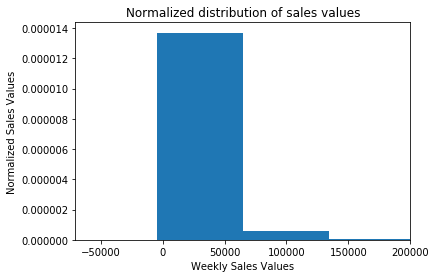

In [12]:
x = np.concatenate((d1[d["Weekly_Sales"] < 0], d1[d["Weekly_Sales"] > 0]))

plt.hist(x, density=True)

plt.xlim([-70496, 200000])
plt.xlabel('Weekly Sales Values')
plt.ylabel('Normalized Sales Values')
plt.title('Normalized distribution of sales values')
plt.show()

<font color = 'blue'>As can be seen, there are some erroneous recording of sales. The sales can not be negative for a particular month, as illustrated in the graph. In the later section we clean the data to remove negative sales</font>

## Data Cleaning

In [13]:
# Filling empty markdown columns
master_df['MarkDown1'] = master_df['MarkDown1'].fillna(0)
master_df['MarkDown2'] = master_df['MarkDown2'].fillna(0)
master_df['MarkDown3'] = master_df['MarkDown3'].fillna(0)
master_df['MarkDown4'] = master_df['MarkDown4'].fillna(0)
master_df['MarkDown5'] = master_df['MarkDown5'].fillna(0)

# Cleaning holiday columns
master_df['isHoliday'] = master_df['IsHoliday_x']
master_df = master_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [14]:
# Handling Date and time
master_df['Date'] = pd.to_datetime(master_df['Date'], format='%Y-%m-%d')
master_df['Week_Number'] = master_df['Date'].dt.week
master_df['Quarter'] = master_df['Date'].dt.quarter
master_df['Month'] = master_df['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
master_df['Season'] = (master_df['Date'].apply(lambda dt: (dt.month%12 + 3)//3)).map(seasons_dict)
master_df["Year"] = master_df["Date"].dt.year

## Creating lagged variables based on time

In [15]:
master_df=master_df.sort_values(by=['Store', 'Dept', 'Year', 'Week_Number'], ascending=True)    

# Previous week sales
shifted_sales = master_df.shift(1)
master_df_new_var = master_df.join(shifted_sales[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year']], rsuffix='_Lag')
master_df_new_var.loc[(master_df_new_var.Dept != master_df_new_var.Dept_Lag) |  (master_df_new_var.Store != master_df_new_var.Store_Lag), 'Weekly_Sales_Lag'] = -2

# Previous month sales
#shifted_sales = master_df.shift(4)
#master_df_new_var = master_df_new_var.join(shifted_sales[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year']], rsuffix='_Lag2')
#master_df_new_var['Monthly_Sales_Lag'] = master_df_new_var.Week_Number_Lag2
#master_df_new_var.loc[((master_df_new_var.Week_Number - master_df_new_var.Week_Number_Lag2) != 4) , 'Monthly_Sales_Lag'] = 0
#master_df_new_var[['Store', 'Dept', 'Week_Number', 'Weekly_Sales', 'Year', 'Weekly_Sales_Lag']]

# Average yearly sales
#my_df= master_df[['Store','Dept','Week_Number','Weekly_Sales']]
#my_df2= my_df.groupby(['Store','Dept','Week_Number']).mean()
#master_df.set_index(['Store','Dept','Week_Number'],inplace= True)
#df=master_df.join(my_df2, rsuffix='_yearly').reset_index(inplace=True)
#master_df_new_var['Yearly_Sales']=df['Weekly_Sales_yearly']

<font color = 'green'>Lagged time varibles play a significant role in explaining current trends and seasonal pattern which repeat over a period of time. Furthermore lag variables capture the inherent store features which can get little tricky to zero out </font>

## Creating dummy variables for categorical values

In [16]:
#forming categorarical variables
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Quarter'], prefix='Quarter'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Season'], prefix='Season'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Store'], prefix='Store'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Dept'], prefix='Dept'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Type'], prefix='Type'))
master_df_new_var = master_df_new_var.join(pd.get_dummies(master_df['Week_Number'], prefix='Week_Number'))

In [17]:
# Removing wrongly recorded data points
master_df_new_var = master_df_new_var.dropna()
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Week_Number'] > 4]
#master_df_new_var = master_df_new_var.loc[master_df_new_var['Monthly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales_Lag'] > 0]
master_df_new_var = master_df_new_var.loc[master_df_new_var['Weekly_Sales'] > 0] #keeping points which are only positive in value for the sales
#master_df_new_var = master_df_new_var.loc[master_df_new_var['MarkDown1'] > 0] #keeping points which are only positive in value for the markdowns
#master_df_new_var = master_df_new_var.loc[master_df_new_var['MarkDown2'] > 0] #keeping points which are only positive in value for the markdowns
#master_df_new_var = master_df_new_var.loc[master_df_new_var['MarkDown3'] > 0] #keeping points which are only positive in value for the markdowns
#master_df_new_var = master_df_new_var.loc[master_df_new_var['MarkDown4'] > 0] #keeping points which are only positive in value for the markdowns
#master_df_new_var = master_df_new_var.loc[master_df_new_var['MarkDown5'] > 0] #keeping points which are only positive in value for the markdowns

In [18]:
master_df_new_var.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Week_Number_43,Week_Number_44,Week_Number_45,Week_Number_46,Week_Number_47,Week_Number_48,Week_Number_49,Week_Number_50,Week_Number_51,Week_Number_52
count,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,...,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000,415976.000000
mean,22.190636,44.214926,16076.358091,136785.695766,60.283127,3.365598,2609.367871,885.598414,467.540133,1091.491239,...,0.021198,0.014085,0.014090,0.014068,0.014188,0.014200,0.014232,0.014265,0.014304,0.014188
std,12.788087,30.521628,22729.328067,60993.165969,18.343033,0.456717,6071.078770,5094.963453,5523.273736,3909.518578,...,0.144045,0.117841,0.117861,0.117772,0.118267,0.118316,0.118444,0.118582,0.118740,0.118267
min,1.000000,1.000000,0.010000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,18.000000,2158.707500,93638.000000,47.090000,2.938000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,37.000000,7711.175000,140167.000000,62.290000,3.461000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,74.000000,20329.532500,202505.000000,74.370000,3.739000,2880.590000,3.000000,4.700000,442.390000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Creating interaction variable

In [19]:
master_df_new_var['MarkDown'] = master_df_new_var['MarkDown1'] + master_df_new_var['MarkDown2'] + master_df_new_var['MarkDown3'] + master_df_new_var['MarkDown4'] + master_df_new_var['MarkDown5']
master_df_new_var['MarkDown*Weekly_Sales_Lag'] = master_df_new_var['MarkDown']*master_df_new_var['Weekly_Sales_Lag']

<font color = 'green'>We created an interaction variable as promotional offers (markdown) and weekly sales go hand in hand. They together explain the future weekly sales in a very robust fashion</font>

# Model Building

## Dividing the dataset into test and train dataset

<font color = 'green'>We will do an out of time validation. The model will be trained on first two years data and tested on the last six months data.</font>

In [20]:
#segregating the data
data_test = master_df_new_var[master_df_new_var.Year == 2012]
data_train = master_df_new_var[master_df_new_var.Year != 2012]

## Building full model linear regression

In [21]:
features = list(master_df_new_var)
for x in ('Quarter',
 'Month',
 'Season',
 'Year',
 'Store',
 'Dept',
 'Date',
 'Type',
 'Weekly_Sales',
 'Weekly_Sales_Lag'):
    features.remove(x)
#features

In [22]:
# Writing the formula
equals_to_str = ""
for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str[:-3] 
equals_to_str_promotion = equals_to_str + "Markdown1"

In [23]:
result_fullmodel = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_fullmodel.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.301e+04
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:11:54   Log-Likelihood:            -2.9899e+06
No. Observations:              289299   AIC:                         5.980e+06
Df Residuals:                  289109   BIC:                         5.982e+06
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

## Exploratory Analysis and descriptive statistics

<font color = 'green'>In this step we are trying to analyze which particular departments contribute to higher sales and thus would play a pivotal role in predicting the sales in future weeks</font>

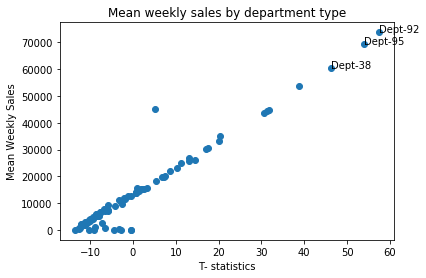

In [24]:
unique_dept_values = master_df_new_var.Dept.unique() #getting unique values of store by department type
unique_data_string = []    #creating null list
mark = []

#creating unique list containing names of department for creating labels for the graph
for counter in range(0, len(unique_dept_values)):
    if unique_dept_values[counter] == 38 or unique_dept_values[counter] == 92 or unique_dept_values[counter] == 95:
        unique_data_string.append("Dept-" + str(unique_dept_values[counter]))
        mark.append("+")
    else:
        unique_data_string.append("")
        mark.append("o")


mean_sales = []   #creating list of mean sales
for intcounter in unique_dept_values:
    mean_sales.append(data_train[data_train["Dept_" + str(intcounter)]==1]["Weekly_Sales"].mean()) #estimating mean sales for store by department type

#creating formula for regression
equals_to_str_dept = "Weekly_Sales ~ Weekly_Sales_Lag + isHoliday + Temperature + Type_A + Type_B + Type_C+ Week_Number_50 + Week_Number_51 + " 
for intcounter in range(len(unique_dept_values)):
    if intcounter != len(unique_dept_values)-1:
        equals_to_str_dept = equals_to_str_dept + "Dept_" + str(unique_dept_values[intcounter]) + " + "
    else:
        equals_to_str_dept = equals_to_str_dept + "Dept_" + str(unique_dept_values[intcounter])

#running regression with relevant variables and all the department type to calculate which department type impacts the weekly sales the most
result_with_dpt = sm.ols(formula=equals_to_str_dept, data = data_train).fit()
result_list = result_with_dpt.tvalues #calculating t value to zero in on important parameters
result_tstat = []
 
for intcounter in range(9,90):
    result_tstat.append(result_list[intcounter]) #getting t stat value for each department and store type
 
fig, ax = plt.subplots()
ax.scatter(result_tstat, mean_sales) #making a scatter plot to highlight high performing departments
plt.xlabel('T- statistics')
plt.ylabel('Mean Weekly Sales')
plt.title('Mean weekly sales by department type')

for i, txt in enumerate(unique_data_string):
    ax.annotate(txt, (result_tstat[i],mean_sales[i])) #identifying the high performing graph and labelling them


<font color = 'blue'>The graph here illustrates  Department 38, 95 and 92 performing extra-ordinarily in terms of mean weekly sales. T-statistics are the values obtained by keeping all the departments as an independent variable in the full model and then observing the significance of these varibles in getting to the response variable (future weekly sale)</font>

<font color = 'green'>We have found out the next set of important variables. They include size, markdown and yearly lag.</font>

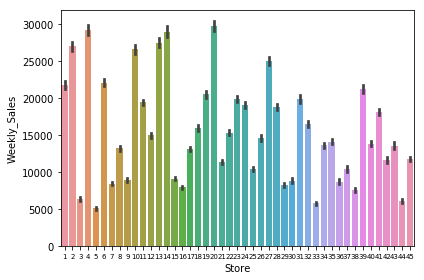

In [25]:
ax= sns.barplot(x="Store", y="Weekly_Sales",  data=master_df_new_var)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

<font color = 'green'>The above graph shows the relative variation in average weekly sales for different stores in Walmart</font>

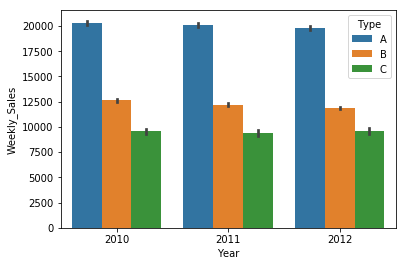

In [26]:
sns.barplot(x="Year", y="Weekly_Sales", hue="Type", data=master_df)

<font color = 'green'>In the above chart we can see the variation in the average sales of type A, type B, and type C stores. Type A store have the highest average sales.</font>

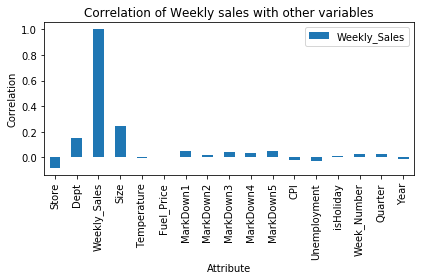

In [27]:
df_corr = master_df.corr()
ax=df_corr[['Weekly_Sales']].plot(kind='bar')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.title('Correlation of Weekly sales with other variables')
plt.tight_layout()
plt.show()

<font color = 'green'>From the above correlation matrix we can see that many factors in the original dataset had week correlation with weekly sales. Therefore, to better explain the weekly sales we have identified new variables like weekly lag and yearly lag which provides a robust time series trend analysis for the future sales.</font>

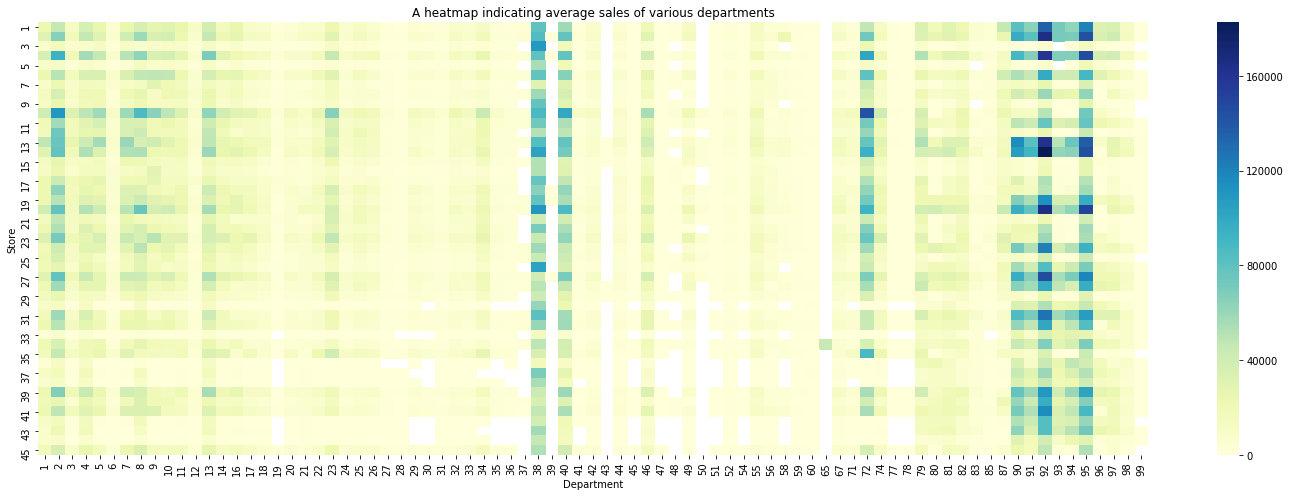

In [28]:
heat_df= master_df[['Store','Dept','Weekly_Sales']]
heat_map=heat_df.groupby(['Store','Dept']).mean()
heat_map.reset_index(inplace=True)
heat_map=heat_map.pivot('Store','Dept','Weekly_Sales')
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(heat_map, cmap="YlGnBu", ax=ax)
plt.xlabel('Department')
plt.ylabel('Store')
plt.title('A heatmap indicating average sales of various departments')
plt.tight_layout()
plt.show()

<font color ='green'>The above heatmap helped us in augmenting our decision of including critical departments like 92, 95, and 38 in our regression equation</font>

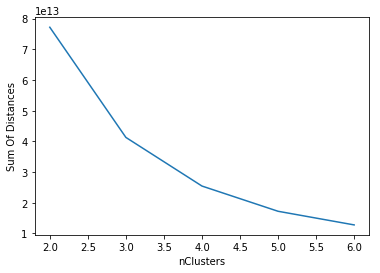

In [29]:
#function to draw pair plot
def drawpairplot(total_clusters, data, blnDraw):
    kmeans=KMeans(n_clusters=total_clusters).fit(data)
    data['Cluster']=kmeans.labels_
    if blnDraw:
        sns.pairplot(data,hue='Cluster')

df = copy.deepcopy(master_df)   #creating a copy of the data frame to not change the master data frame
df["Type"] = df['Type'].map({'A': int(0), 'B': int(1), 'C': int(2)}) #giving numberical values to different store types

nClusters = range(2,7)  #defining a range of clusters between 2 and 7
rel_cols=['Type', 'Weekly_Sales'] #defining the relevant columns in the data set on which clustering needs to run

sumDistances=[]

#calculating SSE
for n in nClusters:
    kmeans=KMeans(n_clusters=n).fit(df[rel_cols])
    sumDistances.append(kmeans.inertia_) #Proxy for SSE

# Plotting the elbow graph
plt.plot(nClusters,sumDistances,'-')
plt.xlabel('nClusters')
plt.ylabel('Sum Of Distances')
plt.show()


As we see a slight kink at cluster = 3. Assuming cluster as 3 and plotting the pair plot


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


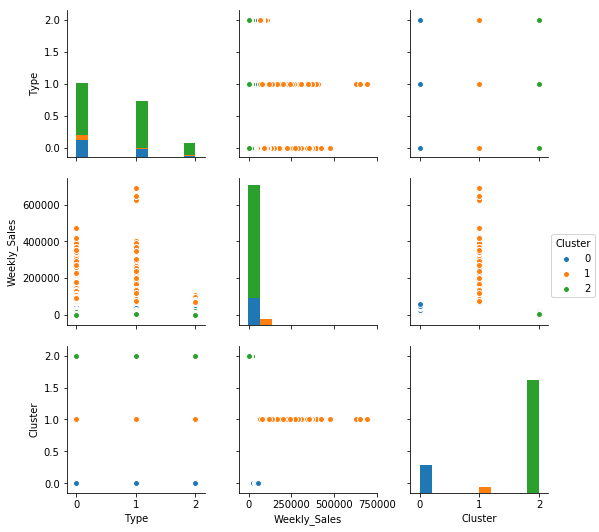

In [30]:
print("As we see a slight kink at cluster = 3. Assuming cluster as 3 and plotting the pair plot")
drawpairplot(3,df[rel_cols],True) #drawing pair plot for 3 clusters

<font color = 'green'>Hence we can see that 3rd cluster which corresponds to "Type A" stores, have the most weekly sales and may be the largest store type amongst the other two stores. The classification of the masked data in the "Type" column of the dataset might indicate the size of the store. </font>

## Variable Shortlisting based on above analysis

In [31]:
features = ['isHoliday', 'Temperature', 'Weekly_Sales_Lag']#, 'Size', 'MarkDown5', 'master_df_new_var']
features.extend(master_df_new_var.columns[master_df_new_var.columns.str.startswith('Type')])
features.remove('Type')

In [32]:
equals_to_str = ""

for i in features:
    equals_to_str = equals_to_str + str(i) + " + "

equals_to_str = str('Weekly_Sales ~ ') + equals_to_str
equals_to_str = equals_to_str  + 'Week_Number_50 + Week_Number_51+ Dept_95 + Dept_92+ Dept_38'
equals_to_str_withpromotion = equals_to_str  + '+ MarkDown*Weekly_Sales_Lag'

## Reduced Models

In [33]:
result_withoutpromotion = sm.ols(formula=equals_to_str, data = data_train).fit()
print("Model 1 without Promotion \n",result_withoutpromotion.summary())

Model 1 without Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 2.099e+05
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:13:53   Log-Likelihood:            -3.0104e+06
No. Observations:              289299   AIC:                         6.021e+06
Df Residuals:                  289288   BIC:                         6.021e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept 

In [34]:
result_withpromotion = sm.ols(formula=equals_to_str_withpromotion, data = data_train).fit()
print("Model 1 with Promotion \n",result_withpromotion.summary())

Model 1 with Promotion 
                             OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                 1.822e+05
Date:                Sat, 21 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:13:54   Log-Likelihood:            -3.0052e+06
No. Observations:              289299   AIC:                         6.010e+06
Df Residuals:                  289286   BIC:                         6.010e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [35]:
data_test = pd.concat([data_test, result_withoutpromotion.predict(data_test).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_test.predicted_values_withoutpromotion, data_test.Weekly_Sales)/data_test.Weekly_Sales.median()))*100, 2), '%.(in the test dataset)')
data_train = pd.concat([data_train, result_withoutpromotion.predict(data_train).rename("predicted_values_withoutpromotion")], axis=1)
print('The accuracy of the model is', round((1-(metrics.median_absolute_error(data_train.predicted_values_withoutpromotion, data_train.Weekly_Sales)/data_train.Weekly_Sales.median()))*100, 2), '%.(in the train dataset)')

The accuracy of the model is 84.56 %.(in the test dataset)
The accuracy of the model is 84.53 %.(in the train dataset)


## Result Plots

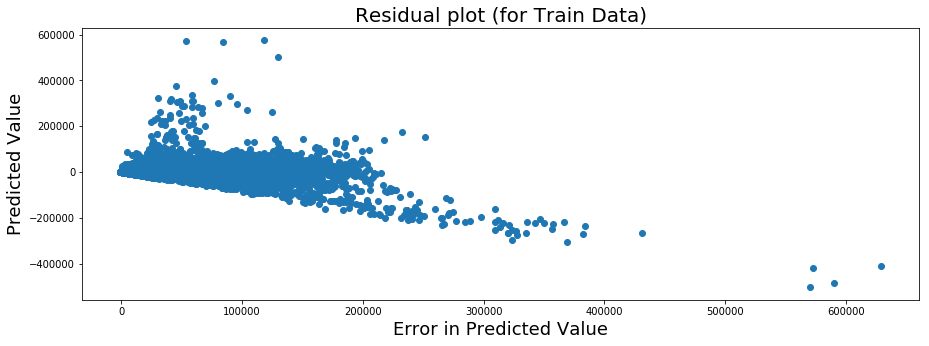

In [36]:
pred_val = result_withoutpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Residual plot (for Train Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

<font color = 'green'>From the above residual plot for the train data we can see that the errors are farely random and we do not see any clear pattern among the residuals. Therefore, we can say that our linear regression does not have any heteroscedasticity</font>

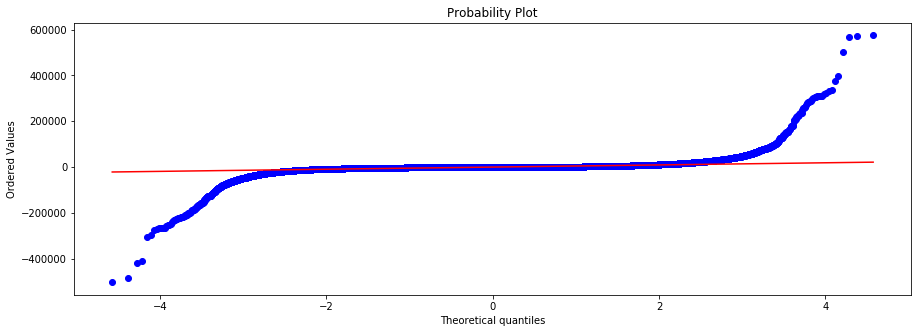

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
#r**2

<font color = 'green'>The above probability plot indicates that the residuals are normally distributed.</font>

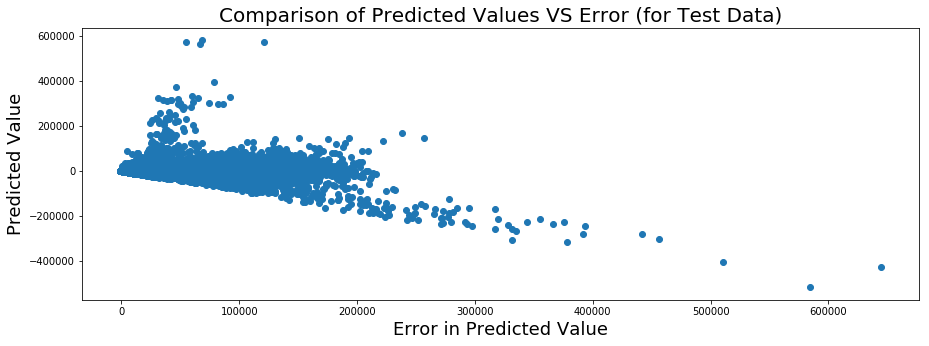

In [38]:
pred_val = result_withpromotion.fittedvalues.copy()
true_val = data_train['Weekly_Sales'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Error in Predicted Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Comparison of Predicted Values VS Error (for Test Data)", fontsize = 20)
_ = ax.scatter(pred_val, residual)

<font color = 'green'>From the above residual plot for the train data we can see that the errors are having fairly finite variance. Therefore, we can say that our linear regression does not have any heteroscedasticity</font>

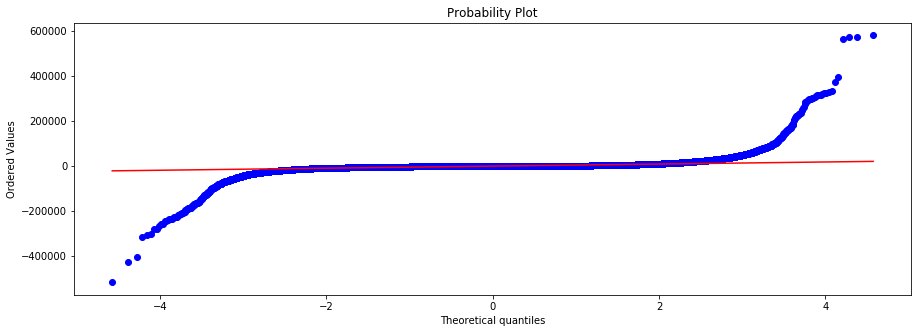

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
#r**2

<font color = 'green'>The above probability plot indicates that the residuals are normally distributed</font>

In [40]:
data_test["predicted_values_withoutpromotion"] = result_withoutpromotion.predict(data_test)
data_test["predicted_values_withpromotion"] = result_withoutpromotion.predict(data_test)

actual_sales = data_test.groupby("Dept").mean()["Weekly_Sales"]
predicted_sales_withoutpromotion = data_test.groupby("Dept").mean()["predicted_values_withoutpromotion"]
#data_test.to_csv("predictedvsactual.csv")


Text(0.5,1,'Scatter plot of Actual Value VS Predicted Value')

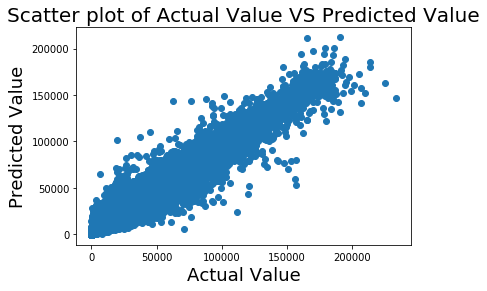

In [41]:
plt.scatter(data_test['Weekly_Sales'], data_test['predicted_values_withpromotion'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)


# Scalability Analysis

## Modifying the regression for scalability purposes

In [42]:
# To calculate L2 norm
def normDiff (x, y, ord=2): 
    return np.linalg.norm (x - y, ord=ord) / np.linalg.norm (y, ord=ord) #Normalized by the "length" of y.

<font color = 'green'>Please note that even though the batchwise regression is currently run on data points, the code to run it on a batch is mentioned in the commented portions.</font>

In [43]:
# Define batchwise regression
def run_ols_batchwise(DataFrame, Formula):
    # Formula will be in this format:
    # 'Weekly_Sales ~ Weekly_Sales_Lag + isHoliday + Temperature + Type_A + Type_B + Type_C+ Week_Number_50 + Week_Number_51'
    df_length = len(DataFrame.index)
    
    # Getting an initial estimate for beta coefficients
    DataFrame.index = range(df_length)
    # We divide the batch into lot of mini-batches. We want to have 10000 records per mini-batch 
    # Few mini-batches will have 10001 records 
    DataFrame['batch_number'] = DataFrame.index % int(df_length/10000)
    result = sm.ols(Formula, DataFrame.loc[DataFrame.batch_number == 1]).fit()
    
    # Extracting relevant columns out of formula
    variables = Formula.split('+')
    variable1 = variables[0].split('~')[1]
    variables.remove(variables[0])
    variables.insert(0, variable1)
    variables.insert(0, 'Constant')
    variables = [x.strip(' ') for x in variables]

    # Preparing the data for interative linear regression
    DataFrame['Constant'] = 1
    X = np.array(DataFrame[variables])
    y = np.array(DataFrame.Weekly_Sales)
    beta_t = np.array(result.params)
    phi = 2/max(result.eigenvals)
    
    for t in range(int(df_length)):
        
        #print("Iteration1:", beta_t)
        #y_data_array = DataFrame[(100*t):(100*(t + 1))]['Weekly_Sales']
        #x_data_array = DataFrame.loc[(100*t):(100*(t + 1))-1, variables]
        #yT = np.array(y_data_array)
        #xT = np.array(x_data_array)
        
        xT = X[t,:]
        yT = y[t]
        
        #print(xT.shape)
        #print(yT.shape)
        #print(beta_t.shape)
        
        #delta_t = phi * xT.T.dot(yT -xT.dot(beta_t))
        
        delta_t = phi * xT.dot(yT -xT.T.dot(beta_t))
        
        beta_t = beta_t + delta_t
    
    return beta_t

In [44]:
# Function calling
batchwise_beta = run_ols_batchwise(data_test, equals_to_str)

In [45]:
print('The mean error (MSE) in predicting the coefficient is ', round(normDiff(batchwise_beta, result_withoutpromotion.params), 4)*100)

The mean error (MSE) in predicting the coefficient is  85.76


# Time complexity analysis

In [54]:
# To measure the time taken to execute the function
def measureTime(fun,arg1):
    nTimes=10
    times=np.zeros(nTimes)
    for i in range(nTimes):
        startTime = time.time()    
        fun(arg1)
        endTime = time.time()
        times[i]=endTime-startTime
    return np.mean(times)

In [55]:
# We use the model to predict the expected sales
def predict(total_obs):
    X = []
    y = []
    for obs in range(total_obs):
        i=random.randint(0, len(data_test))
        x=pd.DataFrame(data_test.iloc[i,:]).T[["isHoliday", "Temperature", "Weekly_Sales_Lag", "Type_A", "Type_B", "Type_C", "Week_Number_50", "Week_Number_51", "Dept_95", "Dept_92", "Dept_38"]]
        x=x.astype(int)
        X.append(x)
        predicted_value = result_withoutpromotion.predict(x)
        y.append(predicted_value)
    return (X, y)

In [56]:
N = 11                                                   # Number of variables is set constant
M = np.geomspace(start=15,stop=1000,num=5,dtype=int)    # Varying the number of observations

times = np.zeros(len(M))
for (i, m) in enumerate(M):
    t = measureTime(predict, m)
    times[i] = t

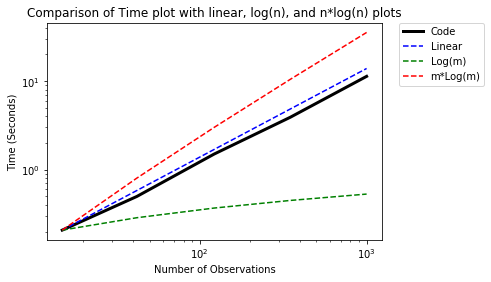

In [57]:
# Creating Benchmarks
linearTime = [times[0]/M[0]*m for m in M]
lognTime = [times[0]/(np.log(M[0]))*(np.log(m)) for m in M]
nlognTime = [times[0]/(M[0]*np.log(M[0]))*(m*np.log(m)) for m in M]
loglognTime = [times[0]/(np.log(M[0])*np.log(M[0]))*(np.log(m)*np.log(m)) for m in M]

# Plotting the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.loglog (M, times, 'k-',linewidth=3,label="Code")

ax1.loglog (M, linearTime, 'b--',label="Linear")
ax1.loglog (M, lognTime, 'g--',label="Log(m)")
ax1.loglog (M, nlognTime, 'r--',label="m*Log(m)")

plt.xlabel('Number of Observations')
plt.ylabel('Time (Seconds)')
plt.title("Comparison of Time plot with linear, log(n), and n*log(n) plots")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Profiling

In [50]:
profile.run('print(predict(20));print(\'=\' * 100)')

([       isHoliday  Temperature  Weekly_Sales_Lag  Type_A  Type_B  Type_C  \
47679          0           74             19065       0       1       0   

       Week_Number_50  Week_Number_51  Dept_95  Dept_92  Dept_38  
47679               0               0        0        0        0  ,        isHoliday  Temperature  Weekly_Sales_Lag  Type_A  Type_B  Type_C  \
78127          0           44              1855       1       0       0   

       Week_Number_50  Week_Number_51  Dept_95  Dept_92  Dept_38  
78127               0               0        0        0        0  ,        isHoliday  Temperature  Weekly_Sales_Lag  Type_A  Type_B  Type_C  \
92115          0           58              9654       1       0       0   

       Week_Number_50  Week_Number_51  Dept_95  Dept_92  Dept_38  
92115               0               0        0        0        0  ,         isHoliday  Temperature  Weekly_Sales_Lag  Type_A  Type_B  Type_C  \
105387          0           84              1092       0       0

      280    0.002    0.000    0.074    0.000 format.py:911(get_result)
       20    0.000    0.000    0.000    0.000 format.py:968(__init__)
       20    0.000    0.000    0.000    0.000 format.py:978(_value_formatter)
       20    0.000    0.000    0.001    0.000 format.py:993(base_formatter)
       20    0.000    0.000    0.430    0.022 frame.py:1944(to_string)
       20    0.000    0.000    0.021    0.001 frame.py:2368(transpose)
      240    0.006    0.000    0.105    0.000 frame.py:2590(_ixs)
      240    0.003    0.000    0.126    0.001 frame.py:2661(__getitem__)
      220    0.001    0.000    0.058    0.000 frame.py:2687(_getitem_column)
       20    0.000    0.000    0.060    0.003 frame.py:2704(_getitem_array)
      220    0.002    0.000    0.025    0.000 frame.py:3090(_box_item_values)
      440    0.004    0.000    0.038    0.000 frame.py:3097(_box_col_values)
      260    0.000    0.000    0.000    0.000 frame.py:320(_constructor)
      520    0.017    0.000    0.558    0.

        5    0.000    0.000    0.000    0.000 socket.py:333(send)
       20    0.000    0.000    0.001    0.000 terminal.py:24(get_terminal_size)
        5    0.000    0.000    0.000    0.000 threading.py:1062(_wait_for_tstate_lock)
        5    0.000    0.000    0.000    0.000 threading.py:1104(is_alive)
        5    0.000    0.000    0.000    0.000 threading.py:506(is_set)
      260    0.002    0.000    0.326    0.001 util.py:151(atleast_2d_column_default)
       20    0.000    0.000    0.000    0.000 util.py:539(safe_scalar_isnan)
       20    0.000    0.000    0.004    0.000 util.py:566(iterable)
      360    0.001    0.000    0.005    0.000 util.py:652(safe_is_pandas_categorical_dtype)
       20    0.000    0.000    0.001    0.000 util.py:658(safe_is_pandas_categorical)
      340    0.002    0.000    0.014    0.000 util.py:690(safe_issubdtype)
    40/20    0.000    0.000    0.001    0.000 wrapper.py:22(__getattribute__)
       80    0.000    0.000    0.000    0.000 wrapper.py:23(<

<font color = 'green'>As can be seen, the majority of the fuction call is spent on fectching the getattribute and length functions both of which are library functions. So, it would seem that this code is optimized. If profiling showed another custom defined function to be consuming the largest memory, then we might want to redefine those particular ones.</font>

In [51]:
%timeit predict(10)

104 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
%load_ext memory_profiler
%memit predict(10)


peak memory: 186.67 MiB, increment: 0.12 MiB


In [53]:
cProfile.run('predict(10)')

         136024 function calls (131364 primitive calls) in 0.196 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       40    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       40    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       40    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:147(__enter__)
       40    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
       40    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       40    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
    30/10    0.000    0.000    0.002    0.000 <frozen importlib._bootstrap>:211(_call_with_frames_removed)
       50    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:222(_verbose_message)
       10    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:3

      160    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x10a197dd8}
      130    0.000    0.000    0.000    0.000 {built-in method _imp.acquire_lock}
       10    0.000    0.000    0.000    0.000 {built-in method _imp.is_frozen}
      130    0.000    0.000    0.000    0.000 {built-in method _imp.release_lock}
       80    0.000    0.000    0.000    0.000 {built-in method _thread.allocate_lock}
       80    0.000    0.000    0.000    0.000 {built-in method _thread.get_ident}
    30/10    0.000    0.000    0.002    0.000 {built-in method builtins.__import__}
      140    0.000    0.000    0.000    0.000 {built-in method builtins.all}
       60    0.000    0.000    0.001    0.000 {built-in method builtins.any}
      140    0.000    0.000    0.000    0.000 {built-in method builtins.callable}
      110    0.003    0.000    0.003    0.000 {built-in method builtins.compile}
      110    0.000    0.000    0.015    0.000 {built-in method builtins.eval}
        

<font color = 'green'>Similar to profile, the majority of the time is spent on the length and assignment operations. Thus, these two function calling should be minimmized for increasing the efficiency.</font>